# AI Recipe Generator  (RNN)

## Abstract

Generative language models and neural networks have emerged as powerful tools for creative content generation, and this includes the creation of culinary recipes. This master's thesis focuses on the exploration and application of advanced generative models in the context of recipe creation.
The study begins with a comprehensive review of the most recent techniques and approaches in the field of text generation and their applicability to recipe generation. The goal of the work is to generate a model whose output is capable of visualizing a new recipe and providing it with meaning and coherence.


Autores:
Gema Blanco del Toro
Sandra Paola Moreno
Joanna Pomes Cobas
Juan Puerta Abad

# Librerias

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json
import zipfile
import pandas as pd

# from google.colab import files

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Python version: 3.10.12
Tensorflow version: 2.12.0
Keras version: 2.12.0


## Loading the dataset

In [2]:
DEBUG = False
DEBUG_EXAMPLES = 10

In [3]:
# Create cache folder.
cache_dir = './tmp'
pathlib.Path(cache_dir).mkdir(exist_ok=True)

In [5]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [6]:
df = pd.read_csv('/kaggle/input/recetastfm/RAW_recipes.csv')
print(f'Número de filas: {df.shape[0]}, Número de columnas:{df.shape[1]}')

Número de filas: 231637, Número de columnas:12


# EDA

In [7]:
df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


We are going to filter the recipes that contain the ingredients within the instructions.

In [8]:
# Define la función para verificar si todos los ingredientes están incluidos en los pasos
def check_ingredients_in_steps(ingredients, steps):
    for ingredient in ingredients:
        if ingredient not in ' '.join(steps):
            return False
    return True

# Aplica la función para crear una nueva columna 'all_ingredients_in_steps'
df['all_ingredients_in_steps'] = df.apply(lambda row: check_ingredients_in_steps(row['ingredients'], row['steps']), axis=1)

# Filtra el DataFrame para obtener solo los registros que cumplen con la condición
filtered_df = df[df['all_ingredients_in_steps']]

In [9]:
dataset_raw = filtered_df.copy()

Nutrition variable treatment. We will separate the data for 'calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates' that are within this column. Subsequently, we will categorize the minutes to have three types of recipes.

In [10]:
def categorizar_tiempo(minutos):
    if minutos <= 30:
        return "Menos de 30 minutos"
    elif minutos <= 60:
        return "Entre 30 y 60 minutos"
    else:
        return "Más de 60 minutos"

# Utiliza la función apply para aplicarla a la columna 'minutos' y crear la nueva columna 'time'.
dataset_raw['time'] = dataset_raw['minutes'].apply(categorizar_tiempo)

# Separamos la variable nutrition en las columnas correspondientes
dataset_raw[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] = dataset_raw.nutrition.str.split(",",expand=True)
dataset_raw['calories'] = dataset_raw['calories'].apply(lambda x: x.replace("[" ,""))
dataset_raw['carbohydrates'] = dataset_raw['carbohydrates'].apply(lambda x: x.replace("]" ,""))
dataset_raw[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] =  dataset_raw[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']].astype(float)

dataset_raw.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,n_ingredients,all_ingredients_in_steps,time,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,7,True,Entre 30 y 60 minutos,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,6,True,Menos de 30 minutos,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,13,True,Más de 60 minutos,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,11,True,Entre 30 y 60 minutos,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,8,True,Más de 60 minutos,352.9,1.0,337.0,23.0,3.0,0.0,28.0


We will categorize the 'calories' into three levels: Low, High, and Medium calorie recipes.

In [11]:
# Definir los límites para las categorías de calorías
calorias_low_limit = dataset_raw['calories'].quantile(1/3)
calorias_high_limit = dataset_raw['calories'].quantile(2/3)

# Función para asignar la categoría a cada valor de calorías
def assign_calorias_level(calorias):
    if calorias <= calorias_low_limit:
        return "Bajo en calorías"
    elif calorias <= calorias_high_limit:
        return "Nivel medio de calorías"
    else:
        return "Alto en calorías"

# Crear la nueva columna "calorias_level" aplicando la función a la columna "calories"
dataset_raw['calories_level'] = dataset_raw['calories'].apply(assign_calorias_level)

## Preprocessing the dataset

#### Filtering out incomplete examples

In [13]:
def recipe_validate_required_fields(recipe):
    required_keys = required_keys = ['name', 'ingredients', 'steps', 'time', 'calories_level']

    if recipe.isnull().any():  # Verifica si hay valores nulos en alguna columna
        return False

    for required_key in required_keys:
        if required_key not in recipe or not recipe[required_key]:
            return False

        if isinstance(recipe[required_key], list) and len(recipe[required_key]) == 0:
            return False

    return True

#### These are the new results after filtering the recipes

In [14]:

dataset_validated = [recipe for index, recipe in dataset_raw.iterrows() if recipe_validate_required_fields(recipe)]
print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 150793
Dataset size AFTER validation 147723
Number of invalide recipes 3070


### Converting recipes objects into strings

In [15]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'
STOP_WORD_TIME = '\n⌚\n\n'
STOP_WORD_CALORIES = '\n⚖️\n\n'

In [17]:
import ast

 # Convertir las cadenas que representan listas en listas de Python

def recipe_to_string(recipe):

    noize_string = 'ADVERTISEMENT'

    title = recipe['name']
    ingredients = ast.literal_eval(recipe['ingredients'])
    instructions = ast.literal_eval(recipe['steps'])
    time = recipe['time']
    calories = recipe['calories_level']

    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'

    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'

    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}{STOP_WORD_TIME}{time}{STOP_WORD_CALORIES}{calories}'

In [18]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  147723


In [19]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 arriba   baked winter squash mexican style

🥕

• winter squash
• mexican seasoning
• mixed spice
• honey
• butter
• olive oil
• salt

📝

▪︎ make a choice and proceed with recipe
▪︎ depending on size of squash , cut into half or fourths
▪︎ remove seeds
▪︎ for spicy squash , drizzle olive oil or melted butter over each cut squash piece
▪︎ season with mexican seasoning mix ii
▪︎ for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece
▪︎ season with sweet mexican spice mix
▪︎ bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin
▪︎ be careful not to burn the squash especially if you opt to use sugar or butter
▪︎ if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking
▪︎ if desired , season with salt

⌚

Entre 30 y 60 minutos
⚖️

Bajo en calorías


Recipe #2
---------
📗 a bit different  breakfast pizza

🥕

• 

### Filtering out large receipts

Recipes come in various lengths. To prepare the recipe sequences for the RNN, we should establish a fixed maximum sequence length in our code. We aim to determine a recipe length that accommodates the majority of use cases while maintaining a small size for optimal training performance

In [21]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

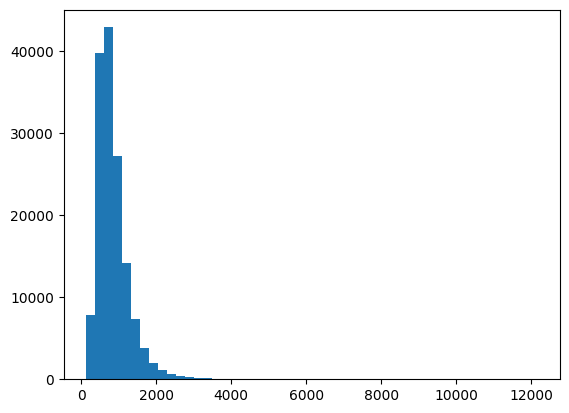

In [22]:
plt.hist(recipes_lengths, bins=50)
plt.show()

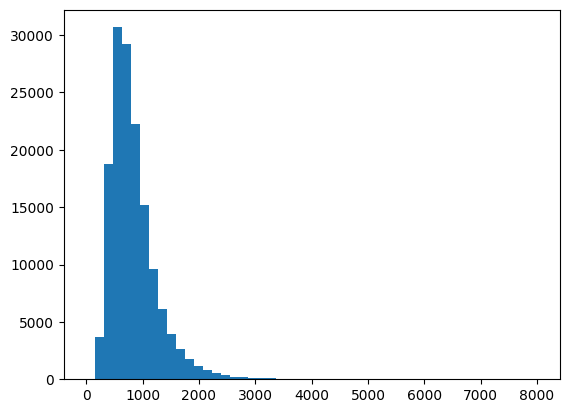

In [23]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [24]:
MAX_RECIPE_LENGTH = 1000
if DEBUG:
    MAX_RECIPE_LENGTH = 700

In [25]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH

In [26]:
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of etiminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  147723
Dataset size AFTER filtering:  109102
Number of etiminated recipes:  38621


In [27]:
if DEBUG:
    dataset_filtered = dataset_filtered[:DEBUG_EXAMPLES]
    print('dataset_filtered.shape, ', len(dataset_filtered))

### Summarizing dataset parameters

In [28]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  1000
TOTAL_RECIPES_NUM:  109102


## Creating vocabulary

To create a vocabulary out of recipes texts we will use [tf.keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

In [29]:
# Indicator de finalización de cada receta.
STOP_SIGN = '␣'

In [30]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [31]:
# Stop word - Aunque no son parte de la receta se deben aclarar al tokenizador su naturaleza
tokenizer.fit_on_texts([STOP_SIGN])

In [32]:
tokenizer.fit_on_texts(dataset_filtered)

In [33]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 109103,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 109102, " ": 11550337, "a": 4214999, "r": 3486230, "i": 3569370, "b": 980241, "k": 665564, "e": 6048652, "d": 2054280, "w": 714925, "n": 3638698, "t": 3834474, "s": 3251054, "q": 41495, "u": 1720625, "h": 1707552, "m": 1429362, "x": 176542, "c": 1955648, "y": 510512, "l": 2566891, "\\n": 3215587, "\\ud83e\\udd55": 109102, "\\u2022": 889355, "o": 4013718, "g": 1183410, "p": 1442293, "v": 527808, "\\ud83d\\udcdd": 109102, "\\u25aa": 907906, "\\ufe0e": 907906, "z": 73946, "f": 784287, ",": 486176, "3": 173587, "5": 101999, "0": 253337, "4": 50584, "\\u231a": 109102, "E": 33298, "6": 72021, "\\u2696": 109102, "\\ufe0f": 109102, "B": 40486, "j": 124507, "\\u00ed": 109102, "2": 95034, "1": 133521, "&": 13073, "-": 111775, "M": 75804, "8": 18398, "\\u00e1": 25694, "N": 36545, "\\"": 11046, "^": 33, "/": 39990, 

In [34]:

VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  85


In [35]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[20])

t
▪


In [37]:
# Characters as vocabulary.
js_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in js_vocabulary])

['', ' ', 'e', 'a', 'o', 't', 'n', 'i', 'r', 's', '\n', 'l', 'd', 'c', 'u', 'h', 'p', 'm', 'g', 'b', '▪', '︎', '•', 'f', 'w', 'k', 'v', 'y', ',', '0', 'x', '3', '1', 'j', '-', '📗', '🥕', '📝', '⌚', '⚖', '️', 'í', '5', '2', 'M', 'z', '6', '4', 'q', 'B', '/', 'N', 'E', 'A', 'á', '8', '7', '&', '9', '!', "'", '"', ':', ')', '(', '@', '~', '#', '%', '[', ']', '=', '+', '?', '`', '{', '}', '>', '^', '<', '$', '_', '|', '\\', '␣']


In [38]:
tokenizer.texts_to_sequences(['📗 yes'])

[[35, 1, 27, 2, 9]]

In [39]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer,f)

## Vectorizing the dataset

Now that we have established a vocabulary, including the relationships between characters and their corresponding codes, we can proceed to transform the collection of recipes from textual format into numerical values. RNN processes numerical inputs rather than text.

In [40]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [41]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

In [42]:
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 109102


In [43]:
print(dataset_vectorized[0][:10], '...')

[35, 1, 3, 8, 8, 7, 19, 3, 1, 1] ...


In [44]:
max_index_example = np.max(dataset_vectorized)

print('max_index_example: ', max_index_example)

max_index_example:  [35, 1, 58, 58, 1, 19, 3, 6, 3, 6, 3, 9, 1, 1, 23, 4, 9, 5, 2, 8, 1, 4, 3, 5, 17, 2, 3, 11, 10, 10, 36, 10, 10, 22, 1, 4, 3, 5, 17, 2, 3, 11, 10, 22, 1, 24, 3, 5, 2, 8, 10, 22, 1, 19, 8, 4, 24, 6, 1, 9, 14, 18, 3, 8, 1, 13, 7, 6, 6, 3, 17, 4, 6, 1, 9, 27, 8, 14, 16, 10, 22, 1, 19, 8, 4, 24, 6, 1, 9, 14, 18, 3, 8, 10, 22, 1, 19, 14, 5, 5, 2, 8, 10, 22, 1, 19, 3, 6, 3, 6, 3, 10, 22, 1, 13, 4, 23, 23, 2, 2, 34, 17, 3, 5, 2, 1, 13, 7, 6, 6, 3, 17, 4, 6, 1, 26, 3, 6, 7, 11, 11, 3, 1, 11, 7, 48, 14, 7, 12, 1, 13, 8, 2, 3, 17, 2, 8, 10, 22, 1, 19, 3, 6, 3, 6, 3, 1, 9, 13, 15, 6, 3, 16, 16, 9, 10, 22, 1, 13, 15, 4, 13, 4, 11, 3, 5, 2, 1, 24, 15, 7, 16, 16, 2, 12, 1, 13, 8, 2, 3, 17, 10, 10, 37, 10, 10, 20, 21, 1, 13, 4, 4, 25, 1, 4, 3, 5, 17, 2, 3, 11, 1, 7, 6, 1, 3, 17, 4, 14, 6, 5, 1, 4, 23, 1, 24, 3, 5, 2, 8, 1, 13, 3, 11, 11, 2, 12, 1, 23, 4, 8, 1, 4, 6, 1, 27, 4, 14, 8, 1, 4, 3, 5, 17, 2, 3, 11, 1, 28, 1, 3, 6, 12, 1, 3, 12, 12, 1, 5, 15, 2, 1, 12, 7, 26, 7, 6, 13, 7, 

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [45]:
recipe_sequence_to_string(dataset_vectorized[0])

📗 arriba  baked winter squash mexican style

🥕

• winter squash
• mexican seasoning
• mixed spice
• honey
• butter
• olive oil
• salt

📝

▪︎ make a choice and proceed with recipe
▪︎ depending on size of squash , cut into half or fourths
▪︎ remove seeds
▪︎ for spicy squash , drizzle olive oil or melted butter over each cut squash piece
▪︎ season with mexican seasoning mix ii
▪︎ for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece
▪︎ season with sweet mexican spice mix
▪︎ bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin
▪︎ be careful not to burn the squash especially if you opt to use sugar or butter
▪︎ if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking
▪︎ if desired , season with salt

⌚

Entre 30 y 60 minutos
⚖️

Bajo en calorías


### Add padding to sequences

In order to facilitate training, it's necessary for all recipes to be of uniform length. To achieve this, we will utilize the tf.keras.preprocessing.sequence.pad_sequences utility. This will involve appending a stop word to the end of each recipe, ensuring they all share the same length.

In [46]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 916
Recipe #2 length: 581
Recipe #3 length: 577
Recipe #4 length: 834
Recipe #5 length: 501
Recipe #6 length: 790
Recipe #7 length: 831
Recipe #8 length: 478
Recipe #9 length: 474
Recipe #10 length: 406


In [47]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [48]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [49]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 1001
Recipe #1 length: 1001
Recipe #2 length: 1001
Recipe #3 length: 1001
Recipe #4 length: 1001
Recipe #5 length: 1001
Recipe #6 length: 1001
Recipe #7 length: 1001
Recipe #8 length: 1001
Recipe #9 length: 1001


In [50]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗 arriba  baked winter squash mexican style

🥕

• winter squash
• mexican seasoning
• mixed spice
• honey
• butter
• olive oil
• salt

📝

▪︎ make a choice and proceed with recipe
▪︎ depending on size of squash , cut into half or fourths
▪︎ remove seeds
▪︎ for spicy squash , drizzle olive oil or melted butter over each cut squash piece
▪︎ season with mexican seasoning mix ii
▪︎ for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece
▪︎ season with sweet mexican spice mix
▪︎ bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin
▪︎ be careful not to burn the squash especially if you opt to use sugar or butter
▪︎ if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking
▪︎ if desired , season with salt

⌚

Entre 30 y 60 minutos
⚖️

Bajo en calorías␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [51]:
max_index_example = np.max(dataset_vectorized_padded)

print('max_index_example: ', max_index_example)

max_index_example:  84


### Create TensorFlow dataset

In [52]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(1001,), dtype=tf.int32, name=None)>


In [53]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [35  1  3 ... 84 84 84] 



Stringified recipe:

📗 arriba  baked winter squash mexican style

🥕

• winter squash
• mexican seasoning
• mixed spice
• honey
• butter
• olive oil
• salt

📝

▪︎ make a choice and proceed with recipe
▪︎ depending on size of squash , cut into half or fourths
▪︎ remove seeds
▪︎ for spicy squash , drizzle olive oil or melted butter over each cut squash piece
▪︎ season with mexican seasoning mix ii
▪︎ for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece
▪︎ season with sweet mexican spice mix
▪︎ bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin
▪︎ be careful not to burn the squash especially if you opt to use sugar or butter
▪︎ if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking
▪︎ if desired , season with salt

⌚

Entre 30 y 60 minutos
⚖️

Bajo en calorías␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

### Split examples on `input` and `target` texts

For each sequence, replicate it and shift to create the input and target text. As an illustration, if the sequence_length is 4 and our text is 'Hello,' the input sequence would be 'Hell,' and the target sequence would be 'ello.

In [54]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]

    return input_text, target_text

In [55]:
dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(1000,), dtype=tf.int32, name=None), TensorSpec(shape=(1000,), dtype=tf.int32, name=None))>


In [56]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()

    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]

    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 1000
Target sequence size: 1000

Input:   '📗   a r r i b a       b a k e d   w i n t e r   s q u a s h   m e x i c a n   s t y l e \n \n 🥕 \n \n •'
Target:  '  a r r i b a       b a k e d   w i n t e r   s q u a s h   m e x i c a n   s t y l e \n \n 🥕 \n \n •  '


In [57]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 35 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 3 ('a')
Step  3
  input: 3 ('a')
  expected output: 8 ('r')
Step  4
  input: 8 ('r')
  expected output: 8 ('r')
Step  5
  input: 8 ('r')
  expected output: 7 ('i')
Step  6
  input: 7 ('i')
  expected output: 19 ('b')
Step  7
  input: 19 ('b')
  expected output: 3 ('a')
Step  8
  input: 3 ('a')
  expected output: 1 (' ')
Step  9
  input: 1 (' ')
  expected output: 1 (' ')
Step 10
  input: 1 (' ')
  expected output: 1 (' ')


### Split up the dataset into batches

In [58]:
print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(1000,), dtype=tf.int32, name=None), TensorSpec(shape=(1000,), dtype=tf.int32, name=None))>


In [59]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  109102
MAX_RECIPE_LENGTH:  1000
VOCABULARY_SIZE:  85


In [60]:
BATCH_SIZE = 64

if DEBUG:
    BATCH_SIZE = DEBUG_EXAMPLES

SHUFFLE_BUFFER_SIZE = 1000

if DEBUG:
    SHUFFLE_BUFFER_SIZE = 1

In [61]:
if DEBUG:
    dataset_train = dataset_targeted \
        .repeat() \
        .batch(BATCH_SIZE, drop_remainder=True)
else:
    dataset_train = dataset_targeted \
      .shuffle(SHUFFLE_BUFFER_SIZE) \
      .batch(BATCH_SIZE, drop_remainder=True) \
      .repeat()

print(dataset_train)

<_RepeatDataset element_spec=(TensorSpec(shape=(64, 1000), dtype=tf.int32, name=None), TensorSpec(shape=(64, 1000), dtype=tf.int32, name=None))>


In [62]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[35  1 32 ... 84 84 84]
 [35  1  3 ... 84 84 84]
 [35  1 47 ... 84 84 84]
 ...
 [35  1 13 ... 84 84 84]
 [35  1 42 ... 84 84 84]
 [35  1 43 ... 84 84 84]], shape=(64, 1000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[ 1 32 58 ... 84 84 84]
 [ 1  3  1 ... 84 84 84]
 [ 1 47 29 ... 84 84 84]
 ...
 [ 1 13  3 ... 84 84 84]
 [ 1 42  1 ... 84 84 84]
 [ 1 43  1 ... 84 84 84]], shape=(64, 1000), dtype=int32)


## Build the model

"We will employ tf.keras.Sequential to define the model for this experiment. In this setup, we will utilize the following layer types:

* tf.keras.layers.Embedding: This serves as the input layer, functioning as a trainable lookup table. It will map the numerical representations of each character to a vector with embedding_dim dimensions.

* tf.keras.layers.LSTM: This is a type of Recurrent Neural Network (RNN) with a size parameter set to rnn_units. (Alternatively, you can also use a GRU layer here.)

* tf.keras.layers.Dense: Serving as the output layer, it will produce outputs equal to vocab_size."

In [63]:

tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))

tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 [==============================] - 0s 119ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[3 3 5 0 2 0 7 2]
 [9 5 2 5 7 8 6 0]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.01129171 -0.01660153  0.00029986 -0.00586665  0.02950886]
  [ 0.01129171 -0.01660153  0.00029986 -0.00586665  0.02950886]
  [-0.04521678  0.04118425  0.02547399 -0.0454331  -0.02174921]
  [ 0.03966601 -0.01174587 -0.03628615 -0.02078437 -0.03195433]
  [-0.04332116  0.02493722 -0.01654083  0.02741772  0.0402387 ]
  [ 0.03966601 -0.01174587 -0.03628615 -0.02078437 -0.03195433]
  [-0.02427933 -0.03886492 -0.04676476  0.04789803 -0.03110373]
  [-0.04332116  0.02493722 -0.01654083  0.02741772  0.0402387 ]]

 [[-0.0303726   0.02058909  0.03777995 -0.03172057  0.04599236]
  [-0.04521678  0.04118425  0.02547399 -0.0454331  -0.02174921]
  [-0.04332116  0.02493722 -0.01654083  0.02741772  0.0402387 ]
  [-0.04521678  0.04118425  0.02547399 -0.0454331  -0.02174921]
  [-0.02427933 -0.03886492 -0.04676476

### Model Definitivo

In [64]:
# Longitud Vocabulario
vocab_size = VOCABULARY_SIZE

# embedding 
embedding_dim = 256

# Número de RNN units.
rnn_units = 1024

In [65]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))
    
    model.add(tf.keras.layers.Dropout(0.2))

    # Agregar la segunda capa LSTM
    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))
    
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [66]:
model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           21760     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dropout (Dropout)           (64, None, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 dropout_1 (Dropout)         (64, None, 1024)          0         
                                                                 
 dense (Dense)               (64, None, 85)            87125     
                                                                 
Total params: 13,748,565
Trainable params: 13,748,565


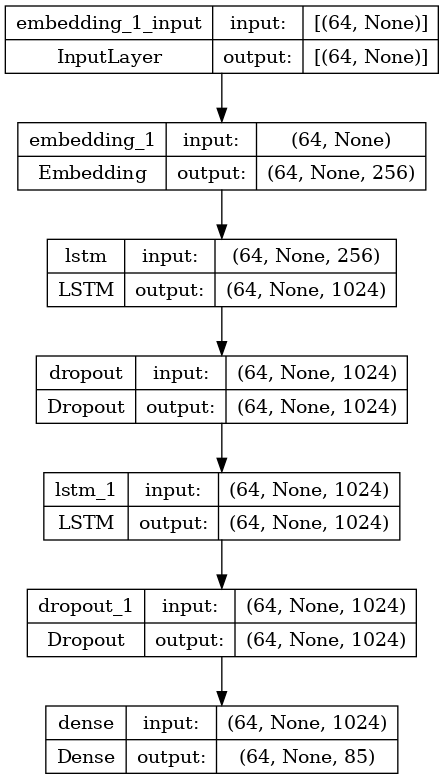

In [67]:
tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

For every character, the model retrieves the corresponding embedding, processes a single time-step using the LSTM with the embedding as input, and then employs the dense layer to produce logits that predict the log-likelihood.


## Trying the model

In [68]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 1000, 85) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [69]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-9.32959083e-04  1.17137586e-03 -1.42708945e-04 -9.59895086e-04
 -6.54201081e-04 -1.82348682e-04 -2.76207229e-05 -3.83773368e-05
  4.24257916e-04  7.14679365e-04 -1.64866273e-04 -2.36946304e-04
 -4.91324347e-04  8.05145712e-04 -2.34130130e-04 -4.09937551e-04
 -2.88327952e-04 -3.79718927e-04 -9.34151525e-04  2.88790325e-04
 -8.25549592e-04  4.44058423e-05 -2.28674093e-04  4.93636704e-04
  5.27599768e-04 -1.99355578e-04  2.22817616e-04 -3.73929768e-04
 -4.04954713e-04  3.37542588e-04 -1.21036595e-04  3.98136472e-04
  1.62695957e-04 -2.72844482e-04  4.47993953e-05 -3.57608747e-04
 -7.98689900e-04 -2.73962098e-04  5.79752959e-05 -3.47886671e-04
 -8.34484759e-04 -8.21106718e-04  6.69892179e-04  1.63435412e-04
  4.58390627e-04  5.74020014e-05  2.00850467e-04 -3.75090109e-04
  1.37259223e-04 -2.60230270e-04  2.09318197e-04 -7.62566633e-04
  1.00994552e-03 -1.90029052e-04  6.01262494e-04 -1.23322621e-04
 -7.44211065e-05  5.02

In [70]:
tmp_logits = [
  [-0.95, 0, 0.95],
];

tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 2 2]], shape=(1, 5), dtype=int64)


In [71]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([1000, 1])

In [72]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(1000,)

In [73]:
sampled_indices[:100]

array([64,  7,  9, 25, 76, 33, 47, 30, 14, 38, 12,  7, 11, 83, 32, 48,  3,
       51, 80,  6,  4, 50, 56, 30, 83, 81, 36, 59,  3, 51, 58, 34, 50, 11,
       20, 40, 12, 41, 84, 69, 15, 37, 51, 66, 19, 73,  4, 20, 34, 65, 13,
       46, 17, 12, 84, 65,  2,  4, 23, 28,  9, 10, 60, 18,  4, 28, 37, 36,
       32,  2, 13, 62,  6, 37, 45,  1, 31, 74, 51, 24, 70, 66, 66,  0, 33,
       67, 55, 74, 36, 41, 81, 66, 49, 80, 32, 34, 40, 72, 31,  4])

In [74]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📗   a       r     b b q   p o r k   s h o u l d e r   s a n d w i c h \n \n 🥕 \n \n •   p o r k   s h o'

Next char prediction:
 '( i s k } j 4 x u ⌚ d i l \\ 1 q a N $ n o / 7 x \\ _ 🥕 ! a N 9 - / l ▪ ️ d í ␣ [ h 📝 N ~ b ? o ▪ - @'


### Trying the model with variable input

In [75]:
for input_example_batch_custom, target_example_batch_custom in dataset_train.take(1):
    random_input = np.zeros(shape=(BATCH_SIZE, 10))
    example_batch_predictions_custom = model_1(random_input)
    print('Prediction shape: ', example_batch_predictions_custom.shape, "# (batch_size, sequence_length, vocab_size)\n")
    print('Custom length input: ')
    print(random_input)

Prediction shape:  (64, 10, 85) # (batch_size, sequence_length, vocab_size)

Custom length input: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

## Training the model

### Attach an optimizer, and a loss function

In [76]:
#Para cada carácter, el modelo busca la incrustación correspondiente, ejecuta el LSTM 
#durante un paso de tiempo con la incrustación como entrada y aplica la capa densa para generar logits que predicen la log-verosimilitud

def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 1000, 85)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 1000)
scalar_loss:       4.4425316


In [77]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configuring checkpoints

If you wish to use checkpoints when running the model, please use this segment of code

In [78]:
 !rm -rf './tmp/checkpoints'
 !rm -rf   '/kaggle/working/ckpt_4.zip'

In [79]:
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [80]:
def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'

    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [81]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [82]:
def initial_epoch_from_latest_checkpoint():
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('_')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [83]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints

### Configuring callbacks

In [87]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [88]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

Configure the training parameters.

In [89]:
INITIAL_EPOCH  = initial_epoch_from_latest_checkpoint()
EPOCHS_DELTA = 12
EPOCHS = INITIAL_EPOCH + EPOCHS_DELTA
STEPS_PER_EPOCH = 1500


print('\n')
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('EPOCHS_DELTA:    ', EPOCHS_DELTA)
print('EPOCHS:          ', EPOCHS)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

Latest checkpoint was not found. Starting from epoch #0


INITIAL_EPOCH:    0
EPOCHS_DELTA:     12
EPOCHS:           12
STEPS_PER_EPOCH:  1500


In [90]:
history_1 = {}
print(history_1)

{}


In [91]:
history_1[INITIAL_EPOCH] = model_1.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    
)

model_name = 'recipe_generation_rrecipesNLG50000_F_' + str(INITIAL_EPOCH) + '.h5'
model_1.save(model_name, save_format='h5')

download_latest_checkpoint(zip_only=True)

Epoch 1/12
1500/1500 [==============================] - 2724s 2s/step - loss: 0.8909
Epoch 2/12
1500/1500 [==============================] - 2732s 2s/step - loss: 0.4323
Epoch 3/12
1500/1500 [==============================] - 2736s 2s/step - loss: 0.3835
Epoch 4/12
1500/1500 [==============================] - 2730s 2s/step - loss: 0.3584
Epoch 5/12
1500/1500 [==============================] - 2732s 2s/step - loss: 0.3484
Epoch 6/12
1500/1500 [==============================] - 2729s 2s/step - loss: 0.3441
Epoch 7/12
1500/1500 [==============================] - 2730s 2s/step - loss: 0.3301
Epoch 8/12
1500/1500 [==============================] - 2729s 2s/step - loss: 0.3227
Epoch 9/12
1500/1500 [==============================] - 2732s 2s/step - loss: 0.3168
Epoch 10/12
1500/1500 [==============================] - 2737s 2s/step - loss: 0.3133
Epoch 11/12
1500/1500 [==============================] - 2736s 2s/step - loss: 0.3091
Epoch 12/12
1500/1500 [==============================] - 2737s 

In [92]:
print(history_1)

{0: <keras.callbacks.History object at 0x7c76004d5b70>}


In [93]:
 model_name = 'recipe_generation_rnn_raw_recipes100000_F.h5'
 model_1.save(model_name, save_format='h5')

### Visualizing training progress

In [94]:
def render_training_history(training_history):
    if 'history' in training_history:
        loss = training_history.history['loss']
    else:
        loss = []
        for initial_epoch in training_history:
            loss += training_history[initial_epoch].history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

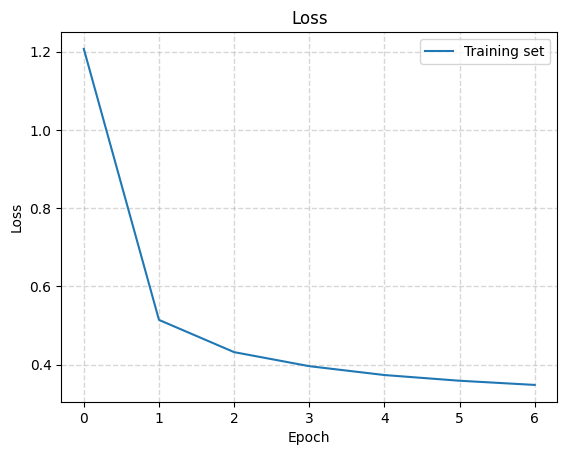

In [124]:
render_training_history(history_1)

## Generating text

In [95]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_12'

In [96]:
simplified_batch_size = 1

model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

model_1_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_1_simplified.build(tf.TensorShape([simplified_batch_size, None]))

In [97]:
model_1_simplified.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            21760     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dropout_2 (Dropout)         (1, None, 1024)           0         
                                                                 
 lstm_3 (LSTM)               (1, None, 1024)           8392704   
                                                                 
 dropout_3 (Dropout)         (1, None, 1024)           0         
                                                                 
 dense_1 (Dense)             (1, None, 85)             87125     
                                                                 
Total params: 13,748,565
Trainable params: 13,748,565


In [128]:
model_1_simplified.input_shape

(1, None)

### The prediction loop

Next, we employ a categorical distribution to determine the index corresponding to the predicted character. This predicted character is then used as the subsequent input for our model.

The RNN state, provided by the model, is reintroduced into the model itself. This enriches the model with additional context, rather than relying solely on a single character. Following the prediction of the next character, these adjusted RNN states are once more incorporated into the model. This iterative process allows the model to learn and benefit from the context provided by the previously predicted characters.


In [100]:

def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Generación de texto usando el modelo
    
    padded_start_string = STOP_WORD_TITLE + "".join(start_string)

    
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # string vacio
    text_generated = []

    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        
        predictions = tf.squeeze(predictions, 0)
        
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

         
        input_indices = tf.expand_dims([predicted_id], 0)

        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [101]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['', '\n', 'a', 'b', 'c', 'o', 'l', 'egg', 'apple', 'rice', 'chicken', 'the', 'strawberry', 'sugar']
    try_letters = ['sugar', ['butter', 'eggs']]
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')
generate_combinations(model_1_simplified)

Attempt: "sugar" + 1.0
-----------------------------------
📗 sugar concentrate flavor instant butter flavor , instant chocolate pudding mix
• sour cream

📝

▪︎ melt butter in a recipe 415 degree oven for 8-9 minutes
▪︎ stir in sour cream and condensed milk , until smooth
▪︎ in glass bowl , combine cool whip and next layer of - cool whip , 1 / 3 of each of pecans and lemon slices , squeezing of resar2mant jelly

⌚

Entre 30 y 60 minutos
⚖️

Nivel medio de calorías␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [ ]:
generate_combinations(model_1_simplified)

## Save the model

In [104]:
model_name = 'recipe_generation_rnn_F.h5'
model_1_simplified.save(model_name, save_format='h5')